# Change Point Detection in Time Series Sensor data

## Install dependent libraries

In [39]:
# Clear all objects from memory
 rm(list=ls())

# Check for installed libraries
 inspkgs = as.data.frame(installed.packages()[,c(1,3:4)])
 inspkgs = inspkgs[is.na(inspkgs$Priority),1:2,drop=FALSE]
 inspkgs[1:3,] # Displying only 3 sample packages


# Run the below commands for libraries installation only 
#    if they are not istalled already as indicated by the above command
#    Uncomment and run the installation commands below

# install.packages("sqldf")
# install.packages("ggplot2")


,Package,Version
bit64,bit64,0.9-7
blob,blob,1.1.0
chron,chron,2.3-50


## Load dependent libraries

In [9]:
library(sqldf)
library(httr)
library(RCurl)
library(bitops)


## Configure parameters required for Change point detection

In [10]:
# Sapecify file names for sample text and configuration files
sampleDataFileName = "sample_sensordata2016.csv"

# Configure Column names in .csv data
v_coltimestamp = "TimeStamp"      # Name of the column which holds the Time stamp of data 
                                              # recorded by Sensor
v_colsensorid = "SensorID"        # Name of the column which holds the Sensor identification
v_colsensorvalue = "SensorValue"  # Name of the column that stores the values measured by sensor

# Set data filter conditions
v_sensorid = "3B1"
v_datatimeformat = "%d-%m-%Y %H:%M:%S"#Time format of the data in the data frame
v_intimezone="GMT"                    #Time zone for the Time stamps
v_rangetimeformat = "%Y%m%d %H:%M:%S" #Time format which is used for specifying the 
                                          # time ranges in the below paraneters
v_Pfrom = "20160324 00:00:00"      #Start Time for first series Time range
v_Pto = "20160325 00:00:00"        #End Time for first series Time range
v_Cfrom = "20160325 00:00:00"      #Start Time for second series Time range
v_Cto ="20160326 00:00:00"         #End Time for second series Time range

# Set the threshold percentage of change if detected
v_thresholdpercent = 25

## Insert credentials for reading the data from csv data store in DSX

In [11]:
# @hidden_cell
# This function accesses a file in your Object Storage. The definition contains your credentials.
# You might want to remove those credentials before you share your notebook.
getObjectStorageFileWithCredentials_273b1c76068e4fe4b6cb7633e12004f3 <- function(container, filename) {
    # This functions returns a textConnection object for a file
    # from Bluemix Object Storage.

    if(!require(httr)) install.packages('httr')
    if(!require(RCurl)) install.packages('RCurl')
    library(httr, RCurl)
    auth_url <- paste("https://identity.open.softlayer.com",'/v3/auth/tokens', sep= '')
    auth_args <- paste('{"auth": {"identity": {"password": {"user": 
                      {"domain": {"id": ', "1301cc61df814635b2dd7c9fa40e6e2a",'},
                       "password": ',"mHk4F6cpWl5R?*jZ",',
                       "name": ', "member_03c4778cda0f6111933c34cba4d34b7a50f6eabb",'}},
                       "methods": ["password"]}}}', sep='"')
    auth_response <- httr::POST(url = auth_url, body = auth_args)
    x_subject_token <-  headers(auth_response)[['x-subject-token']]
    auth_body <-  content(auth_response)
    access_url <-  unlist(lapply(auth_body[['token']][['catalog']], function(catalog){
        if((catalog[['type']] == 'object-store')){
            lapply(catalog[['endpoints']], function(endpoints){
                if(endpoints[['interface']] == 'public' && endpoints[['region_id']] == 'dallas') {
                    paste(endpoints[['url']], container, filename, sep='/')}
            })
        }
    }))
    data <- content(httr::GET(url = access_url, add_headers ("Content-Type" = "application/json", 
                                                             "X-Auth-Token" = x_subject_token)), as="text")
    textConnection(data)
}


# Function to translate from one datetime format to another datetime format

Returns character strings in the converted format NOT in posix or datetime format <br/>
DateTime passed in also should be in character string format

In [12]:
dtformatconvert <- function(indatetimes, fromdatetimeformat="%Y-%m-%d %H:%M:%S %p", 
                            todatetimeformat="%d-%m-%Y %H:%M:%S",
                            fromtz="GMT", totz="", usetz=FALSE)
    {
        return(strftime(as.POSIXct(indatetimes, format=fromdatetimeformat, tz=fromtz, usetz=FALSE), 
                            format=todatetimeformat, tz=totz, usetz=FALSE))
    }


# Call function to read data for specific sensor
Copy the code snippet that resembles  <br/>
        [getObjectStorageFileWithCredentials_273b1c76068e4fe4b6cb7633e12004f3] <br/> 
        from your own Insert credentials step section and replace below before reading the data <br/>
Also replace the .csv file name in the call to the above function for your environment

In [14]:
alarmdf <-  read.csv(file = 
             getObjectStorageFileWithCredentials_273b1c76068e4fe4b6cb7633e12004f3("ChangePointDetection", 
                                                                                  sampleDataFileName));

head(alarmdf)


SensorID,TimeStamp,SensorValue,SensorUnits
3B1,20-03-2016 17:40:00,10.455,FAHRENHEIT
3B1,20-03-2016 17:50:00,9.840,FAHRENHEIT
3B1,20-03-2016 18:00:00,9.840,FAHRENHEIT
3B1,20-03-2016 18:10:00,24.600,FAHRENHEIT
3B1,20-03-2016 18:20:00,12.915,FAHRENHEIT
3B1,20-03-2016 18:30:00,10.455,FAHRENHEIT


### Filter data for 1 sensor for analysis <br/>
### Standardise the Dataset with standard column names <Timestamp, SensorID, SensorValue> <br/>

You can investigate the set of unique sensor ids in the data using the below command <br/>
[unique(alarmdf$SensorID)]

In [15]:
alarmdf <- f_readsensordata(sensordf = alarmdf, 
                            sensorid = v_sensorid, 
                            coltimestamp = v_coltimestamp, colsensorid=v_colsensorid, 
                            colsensorval=v_colsensorvalue)

head(alarmdf)

TimeStamp,SensorID,SensorValue
20-03-2016 17:40:00,3B1,10.455
20-03-2016 17:50:00,3B1,9.840
20-03-2016 18:00:00,3B1,9.840
20-03-2016 18:10:00,3B1,24.600
20-03-2016 18:20:00,3B1,12.915
20-03-2016 18:30:00,3B1,10.455


### Sort the data by Time stamp (optional if specific time series based functions not applied)

In [18]:
alarmdf <- alarmdf[with(alarmdf, order(SensorID, 
                                       as.POSIXct(TimeStamp,format=v_datatimeformat, tz=v_intimezone))), ];

head(alarmdf)


TimeStamp,SensorID,SensorValue
20-03-2016 17:40:00,3B1,10.455
20-03-2016 17:50:00,3B1,9.840
20-03-2016 18:00:00,3B1,9.840
20-03-2016 18:10:00,3B1,24.600
20-03-2016 18:20:00,3B1,12.915
20-03-2016 18:30:00,3B1,10.455


## Function to split data into 2 datasets: Previous, Current

IN: Standard Data Frame, SensorID, <br/>
    Previous From Time stamp, Previous To Time stamp, <br/>
    Current From Time Stamp, Current To Time Stamp <br/>
OUT: Data series <br/>
    series 1 (SensorID, TimeStamp, SensorValue), <br/>
    series 2 (SensorID, TimeStamp, SensorValue) <br/>

In [19]:
f_splitdataseries <- function(SensorID, Intimeformat, Datatimeformat, PFrom, PTo, CFrom, CTo)
{
  PFromPOSIX = as.POSIXct(PFrom, format=Intimeformat, tz="GMT", usetz=FALSE);
  PToPOSIX = as.POSIXct(PTo, format=Intimeformat, tz="GMT", usetz=FALSE);
  CFromPOSIX = as.POSIXct(CFrom, format=Intimeformat, tz="GMT", usetz=FALSE);
  CToPOSIX = as.POSIXct(CTo, format=Intimeformat, tz="GMT", usetz=FALSE);
  
  alarmdf$TimeStampPOSIX <- as.POSIXct(alarmdf$TimeStamp, format=Datatimeformat, tz="GMT", usetz=FALSE);
  
  series1 = alarmdf[which(alarmdf$SensorID ==SensorID & 
                          alarmdf$TimeStampPOSIX >= PFromPOSIX & alarmdf$TimeStampPOSIX < PToPOSIX),];
  series2 = alarmdf[which(alarmdf$SensorID ==SensorID & 
                          alarmdf$TimeStampPOSIX >= CFromPOSIX & alarmdf$TimeStampPOSIX < CToPOSIX),];
  return(list(series1, series2));
}


## Split data into 2 divergent sets for detecting changes

### Get the 2 Data series to compare

In [20]:
# Get the 2 Data series to compare (sample values shown for help)
# s = f_splitdataseries (SensorID="3B1",
#                       Intimeformat="%Y%m%d %H:%M:%S", Datatimeformat="%d-%m-%Y %H:%M:%S",
#                       PFrom="20160324 00:00:00", PTo="20160325 00:00:00",
#                       CFrom="20160325 00:00:00", CTo="20160326 00:00:00")

s = f_splitdataseries (SensorID=v_sensorid,
                       Intimeformat=v_rangetimeformat, Datatimeformat=v_datatimeformat,
                       PFrom=v_Pfrom, PTo=v_Pto,
                       CFrom=v_Cfrom, CTo=v_Cto)


# Unpack the 2 list of data frames
series1 <- s[[1]]
series2 <- s[[2]]

head(series1)
head(series2)

,TimeStamp,SensorID,SensorValue,TimeStampPOSIX
471,24-03-2016 00:00:00,3B1,9.225,2016-03-24 00:00:00
472,24-03-2016 00:10:00,3B1,8.610,2016-03-24 00:10:00
473,24-03-2016 00:20:00,3B1,8.610,2016-03-24 00:20:00
474,24-03-2016 00:30:00,3B1,8.610,2016-03-24 00:30:00
475,24-03-2016 00:40:00,3B1,8.610,2016-03-24 00:40:00
476,24-03-2016 00:50:00,3B1,8.610,2016-03-24 00:50:00


,TimeStamp,SensorID,SensorValue,TimeStampPOSIX
615,25-03-2016 00:00:00,3B1,18.450,2016-03-25 00:00:00
616,25-03-2016 00:10:00,3B1,13.530,2016-03-25 00:10:00
617,25-03-2016 00:20:00,3B1,12.300,2016-03-25 00:20:00
618,25-03-2016 00:30:00,3B1,11.685,2016-03-25 00:30:00
619,25-03-2016 00:40:00,3B1,11.685,2016-03-25 00:40:00
620,25-03-2016 00:50:00,3B1,16.605,2016-03-25 00:50:00


### Function to plot the line graphs for both the series <br/>
IN parameters: (x,y values for both the Time series in sorted order) x1, y1, x2, y2


In [21]:
f_plot2lines <- function(x1, y1, x2, y2)
{
  # Draw Line plot
  # dev.new()
  plot(y1,type="l",col="green",xlab=" ", ylab=" ",pch=21,xaxt="n",yaxt="n")
  par(new=T)
  plot(y2,type="l",col="red",xlab="Time", ylab="Sensor Values",pch=21,xaxt="n",yaxt="n")
  axis(2,las=3,cex.axis=0.8)
  axis(1,at=c(1:length(x1)),c(x1),las=2,cex.axis=0.4)
  title("Sensor readings by Time overlay")
  par(new=F)
}


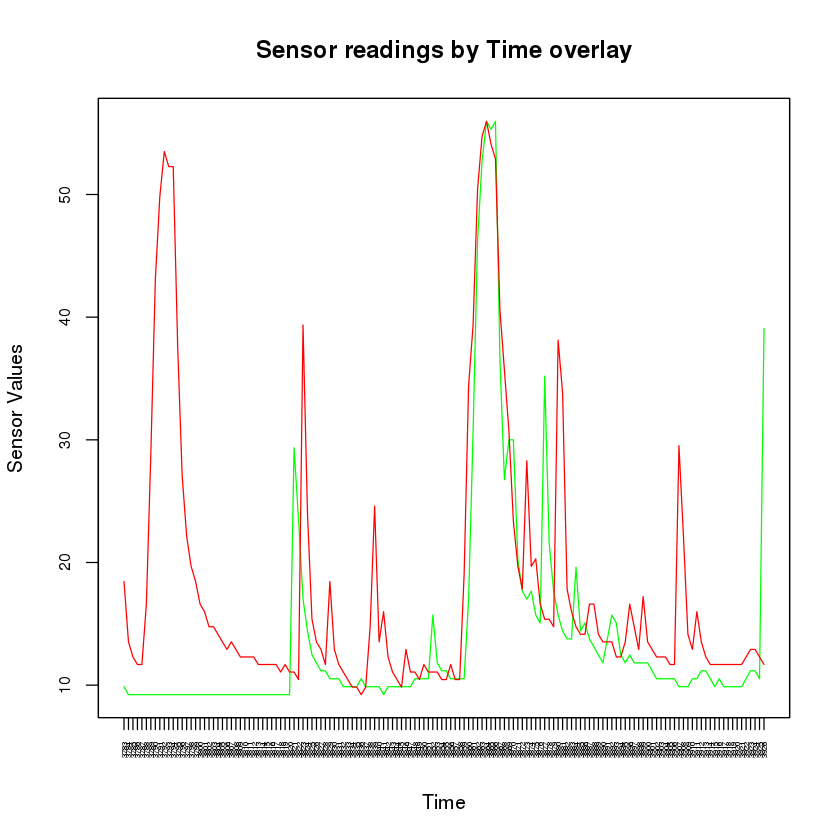

In [22]:
# Line plot of the 2 Data series
f_plot2lines(x1 <- series1$TimeStamp, y1 <- series1$SensorValue,
             x2 <- series2$TimeStamp, y2 <- series2$SensorValue)


### Function to plot the box plots for both the distributions <br/>
Time series order does not matter for this <br/>
    IN parameters: (Sensorvalues-series 1, Sensorvalues-series 2)

In [23]:
f_plot2boxes <- function(s1sensorvalue, s2sensorvalue)
{
  data_list = NULL
  col_list = c("green", "blue")
  names_list = c("Previous", "Current")
  
  data_list = list()
  data_list[[1]] = s1sensorvalue
  data_list[[2]] = s2sensorvalue
  
  # dev.new() # Works in PC only
  boxstats <- boxplot.stats(data_list[[1]], coef=1.57, do.conf = TRUE, do.out = TRUE)
  #par(new=T)
  boxplot(data_list, las = 2, col = col_list, ylim=c(-2.0,70),
          names= names_list,
          mar = c(12, 5, 4, 2) + 0.1,
          main="Change point detection",
          sub=paste("Spread of Sensor reading distributions", ":", sep=""),
          ylab="Sensor Readings", 
          coef=1.57, do.conf = TRUE, do.out = TRUE)
  abline(h=boxstats$stats, col="green", las=2)
}


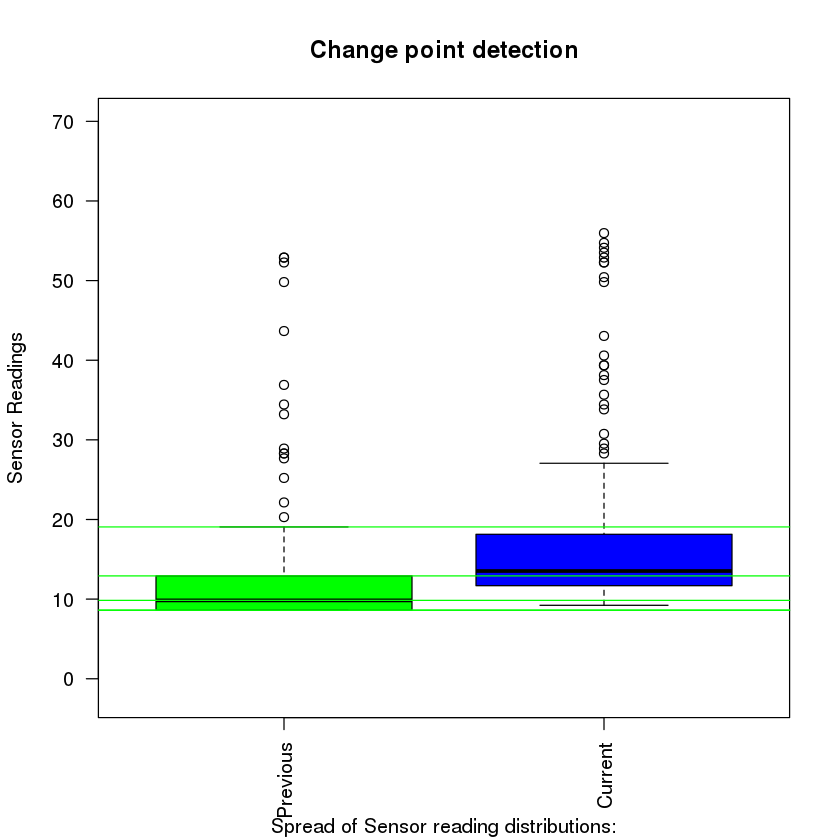

In [24]:
# Plot the 2 box plots for the distribution
f_plot2boxes(s1sensorvalue = series1$SensorValue,
             s2sensorvalue = series2$SensorValue)


## Function to calculate the stats for both the series <br/>
Avg, Median, p1sd, p2sd, p3sd, n1sd, n2sd, n3sd, q0, q1, q2, q3, q4, f1range, <br/>
     iqrange, f2range, sku, kurt, outliers


In [25]:
f_seriesstats <- function(series)
{
  boxstats <- boxplot.stats(series, coef=1.57, do.conf = TRUE, do.out = TRUE)
  smin <- min(series)
  smax <- max(series)
  smean <- mean(series)
  #Spread measures
  sq0 <- boxstats$stats[1]
  sq1 <- boxstats$stats[2]
  sq2 <- boxstats$stats[3]
  sq3 <- boxstats$stats[4]
  sq4 <- boxstats$stats[5]
  siqr <- (sq3 - sq1)
  # Normal distribution
  s1sd <- sd(series)
  s1sdp <- smean + s1sd
  s1sdn <- smean - s1sd
  s2sdp <- smean + (2*s1sd)
  s2sdn <- smean - (2*s1sd)
  s3sdp <- smean + (3*s1sd)
  s3sdn <- smean - (3*s1sd)
  # Outlier counts @ 2sd
  s2sdout <- sum(series > s2sdp) + sum(series < s2sdn)
  # return(list(smin, smax, smean, sq0, sq1, sq2, sq3, sq4, siqr, s1sd, s1sdp, s1sdn, s2sdp, s2sdn, s3sdp, s3sdn))
  return(list(smin=smin, smax=smax, smean=smean,
              sq0=sq0, sq1=sq1, sq2=sq2, sq3=sq3, sq4=sq4, siqr=siqr,
              s1sd=s1sd, s1sdp=s1sdp, s1sdn=s1sdn,
              s2sdp=s2sdp, s2sdn=s2sdn, s3sdp=s3sdp, s3sdn=s3sdn))
}


## Compute the statistics for both series and check results

In [26]:
# Compute the statistics for both series and check results
s1stats <- f_seriesstats(series1$SensorValue)
s2stats <- f_seriesstats(series2$SensorValue)


## Functions to calculate change point deviatrions

In [27]:
## Function to calculate change point deviatrion percentages
f_changepercent <- function(val1, val2)
{
  return(((val2-val1)/val1)*100)
}

# Calculate percentage deviation for individual stats
f_serieschangepercent <- function(series1stats, series2stats)
{
  n <- length(series1stats)
  cols=names(series2stats)
  cpdf <- data.frame(statname=character(), series1val = numeric(), 
                     series2val=numeric(), changeper=numeric());
  for (i in 1:length(series2stats))
  {
    newrow = data.frame(statname=cols[i], 
                        series1val=series1stats[[i]], 
                        series2val=series2stats[[i]], 
                        changeper=f_changepercent(series1stats[[i]], series2stats[[i]]))
    cpdf <- rbind(cpdf, newrow)
  }
  return(cpdf)
}

# Calculate overall percentage deviation and detect change point
f_detectchangepoint <- function(dfcp, threshold)
{
  # Overall percentage deviation
  newrow = data.frame(statname='overall',
                      series1val=NA,
                      series2val=NA,
                      changeper=mean(abs(dfcp$changeper)))
  dfcp <- rbind(dfcp, newrow)
  # Overall change point percentage
  changepointper <- dfcp[which(dfcp$statname=="overall"),c("changeper")]
  # Mark change point at threshold %
  if(changepointper > threshold)
    {return(paste("Change Point DETECTED exceeding threshold: ",threshold,"% ", sep=""))}
  else
    {return(paste("Change Point NOT DETECTED at threshold: ",threshold,"% ", sep=""))}
}


## Overall change percentage and individual key statistics


In [28]:
# Overall change percentage in key statistics
dfallstats <- f_serieschangepercent(s1stats, s2stats)
print(dfallstats)
# Detect changepoint
f_detectchangepoint(dfallstats, v_thresholdpercent)


   statname series1val series2val changeper
1      smin   8.610000   9.225000  7.142857
2      smax  52.890000  55.965000  5.813953
3     smean  13.073021  18.168125 38.974191
4       sq0   8.610000   9.225000  7.142857
5       sq1   8.610000  11.685000 35.714286
6       sq2   9.840000  13.530000 37.500000
7       sq3  12.915000  18.142500 40.476190
8       sq4  19.065000  27.060000 41.935484
9      siqr   4.305000   6.457500 50.000000
10     s1sd   8.861824  11.444024 29.138478
11    s1sdp  21.934845  29.612149 35.000497
12    s1sdn   4.211197   6.724101 59.671956
13    s2sdp  30.796669  41.056174 33.313685
14    s2sdn  -4.650627  -4.719924  1.490057
15    s3sdp  39.658493  52.500198 32.380721
16    s3sdn -13.512451 -16.163948 19.622625


[1] "Change Point DETECTED exceeding threshold: 25% "